# Setup
## Import and Git

In [32]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
import git

import networkx as nx
import random
from collections import defaultdict
from matplotlib import pyplot as plt 
import json
import pandas as pd
import seaborn as sns
import numpy as np

In [33]:
def get_git_root():
    repo = git.Repo(search_parent_directories=True)
    return repo.git.rev_parse("--show-toplevel")
root = get_git_root()

## Brightway setup

In [34]:
bd.projects.set_current('SEE_LAB') 
eidb = bd.Database("ecoinvent-3.9.1-cutoff")

# Exploration

## Brightway structure

In [35]:
random_act = eidb.random()
random_act.as_dict()

{'comment': 'This dataset describes all the processes and material inputs needed to produce a aluminium window frame with 1 m2 visible area. 1 m2 of visible aluminium window frame weighs 50.7 kg.\n[This dataset was already contained in the ecoinvent database version 2. It was not individually updated during the transfer to ecoinvent version 3. Life Cycle Impact Assessment results may still have changed, as they are affected by changes in the supply chain, i.e. in other datasets. This dataset was generated following the ecoinvent quality guidelines for version 2. It may have been subject to central changes described in the ecoinvent version 3 change report (http://www.ecoinvent.org/database/ecoinvent-version-3/reports-of-changes/), and the results of the central updates were reviewed extensively. The changes added e.g. consistent water flows and other information throughout the database. The documentation of this dataset can be found in the ecoinvent reports of version 2, which are stil

In [36]:
random_exc = [exc for exc in random_act.exchanges()][0].as_dict()
random_exc

{'flow': '1b7f1f4d-3af5-479b-9fcc-6f5be96f9791',
 'type': 'production',
 'name': 'window frame, aluminium, U=1.6 W/m2K',
 'classifications': {'CPC': ['42120: Doors, windows and their frames and thresholds for doors, of iron, steel or aluminium']},
 'production volume': 1.32236940655721,
 'properties': {'carbon allocation': {'amount': 7.243818868599742,
   'unit': 'kg'},
  'carbon content': {'amount': 0.142876111806701, 'unit': 'dimensionless'},
  'carbon content, fossil': {'amount': 0.142876111806701,
   'comment': 'Calculated as an addition of C content in the product (in Tab 4.2, ecoinvent v2.2 report 7-part XXVI), then referred to 1 kg DM',
   'unit': 'dimensionless'},
  'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'},
  'dry mass': {'amount': 50.7, 'unit': 'kg'},
  'heating value, net': {'amount': 219.49,
   'comment': 'LHV is calculated based on the Carbon content of the product. More details can be found on the respective documentation.',
   'unit': 'MJ'},


As we can see, each exchange stores an "input" and "ouput" var (when treated as a dict). 

Our goal is to use this exchange as an edge between the two nodes.

So first we'll get make just a node graph of all the processes (and maybe a bipartite network between biosphere and technosphere?)

And then we'll iterate through all the edges and join them.


**Note**: from the initial import as well as manually iterating (deleted), we know that t process count is 21238, while the exchange count is 674593 (for ecoinvent 3.9.1 -- but maybe we should upgrade to 3.11)



## Case study: make a graph from the database

In [37]:
G = nx.DiGraph()

## attach the nodes
for act in eidb:
    G.add_node(act['code'], **act)

G.number_of_nodes()

21238

In [38]:
G.nodes['e495b85a7516ed20273027cd2e3804fe']

{'comment': 'This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis dataset represents the global market for Cross-laminated timber (CLT). \nCLT production is geographically much focused on Alpine Europe, where the technology was originally developed. For example, Austria, Germany, and Switzerland together had almost 80% of global production capacity in 2015, whereby Austria alone holds 60% of global capacity (Muszynski et al., 2017). Other producing regions include France, the UK, Finland, Latvia, Japan, and the US.\nThe global annual production of CLT was estimated between 600,000 m3 in 2013 and one million m3 in 2015 (Muszynski et

In [39]:
random_node = eidb.random()
print(random_node)
print(json.dumps(
    random_node.as_dict(), indent=4))

'market for land tenure, arable land, measured as carbon net primary productivity, annual crop' (kilogram, BR-AL, None)
{
    "comment": "This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis market represents the mix of land tenure 'land tenure, arable land, measured as carbon net primary productivity, annual crop', in Brazil, Alagoas. This is land that is made accessible for cultivation after deforestation, transformation from primary or secondary forest, or change from annual to perennial crops (or vice versa), and is used by activities modelling land use change only.\nThe production volumes and market shares of land tenure and L

In [40]:
random_exc = [exc for exc in eidb.random().exchanges()][0]
print(random_exc)
print(json.dumps(
    random_exc.as_dict(), indent=4))

Exchange: 1.0 kilogram 'petroleum and gas production, onshore' (kilogram, CA, None) to 'petroleum and gas production, onshore' (kilogram, CA, None)>
{
    "flow": "e6aad2de-0b1b-49c3-a0c4-797ba34d87e5",
    "type": "production",
    "name": "petroleum",
    "classifications": {
        "CPC": [
            "12010: Petroleum oils and oils obtained from bituminous minerals, crude"
        ]
    },
    "production volume": 254790000000.0,
    "properties": {
        "carbon allocation": {
            "amount": 0.84,
            "unit": "kg"
        },
        "carbon content": {
            "amount": 0.84,
            "unit": "dimensionless"
        },
        "carbon content, fossil": {
            "amount": 0.84,
            "comment": "Based on Meili et al. (2022) section 5.1",
            "unit": "dimensionless"
        },
        "carbon content, non-fossil": {
            "amount": 0.0,
            "unit": "dimensionless"
        },
        "dry mass": {
            "amount": 1.0,
 

Note that we have a choice of edge weight here. Possible options include:

* Production Volume -- how much is produced per yearso to speak. So maybe that means 482279000.0 kg of peanuts per annual year. 
* Any of the properties eg:
    * carbon acollocation 
    * carbon content
    * price 
    * amount -- the actual specific quantity. this is what is evaluated by impact assessment calculations.

But none of them *really* make sense to me to use. I suspect in the end we'll probably end up using different ones for different analysis for different types of processes.


I think probably the most sensible "standard," though, is amount. 

In [41]:
## Build the exchanges
for act in eidb:
    for exc in act.exchanges():
        input_node = exc["input"][1]
        output_node = exc["output"][1]
        carbon_content = exc.get('properties', {}).get('carbon content', {}).get('amount', 0)
        carbon_allocation = exc.get('properties', {}).get('carbon allocation', {}).get('amount', 1)
        
        # Calculate carbon flow for the edge
        carbon_flow = carbon_content * carbon_allocation
        # Add edge to the graph
        G.add_edge(input_node, output_node, carbon_flow=carbon_flow, **exc)



In [42]:
G.nodes['4695730316b4d42e7f6f52a22aebee63']

{'comment': 'This activity represents the reduction of pressure, from high to low, for the distribution of natural gas [m3] to end-users. \nIncluded activities start:  Only the input of natural gas at high pressure (from regional distribution) considered in this activity.\nIncluded activities end:  Pressure reduction from high to low pressure, for supply to local distribution network. Energy requirements, losses and emissions, and infrastructure for the distribution at the different pressure levels are considered in the corresponding market activities. \nGeography:  This geography represents the subset of European countries, excluding the following: Belgium, Switzerland, Germany, Spain, France, United Kingdom, italy, Netherlands\nTechnology:  Within this dataset, natural gas gas at high pressure(1-5 bar overpressure) is converted to low pressure (0.1 bar overpressure) for local distribution, e.g., for residential use.',
 'classifications': [('ISIC rev.4 ecoinvent',
   '3520:Manufacture

The above is the activity for reducing the pressure of a natural gas for high pressure to low pressure for the "Rest of Europe," that is, the average of the nations not explicitly defined.

It's exchanges are what link this process to other processes. From ecoquery we see that they are: 

* Consuming
    * market for natural gas, low pressure, ROE

* Inputs
    * market for natural gas, high pressure AT
    * market for natural gas, high pressure CZ

In [43]:
out_edges = G.out_edges('4695730316b4d42e7f6f52a22aebee63', data=True)
for u, v, edge_data in out_edges:
    # Print edge info with formatted data
    edge_data_str = json.dumps(edge_data, indent=4)  # Pretty-print the edge data
    print(f"Edge from {u} to {v} with data:\n{edge_data_str}")
    print(f"\tHas location: {G.nodes[u].get('location', 'No location attribute')} \n")


Edge from 4695730316b4d42e7f6f52a22aebee63 to 40bccd8d0b93d2e058476865a14f0a52 with data:
{
    "carbon_flow": 0.40357453499999996,
    "flow": "609fae33-2e89-4b99-8129-b1f80a6dda33",
    "type": "technosphere",
    "name": "natural gas, low pressure",
    "classifications": {
        "CPC": [
            "69120: Gas distribution through mains (on own account)"
        ]
    },
    "production volume": 0.0,
    "properties": {
        "carbon allocation": {
            "amount": 0.544635,
            "unit": "kg"
        },
        "carbon content": {
            "amount": 0.741,
            "unit": "dimensionless"
        },
        "carbon content, fossil": {
            "amount": 0.741,
            "unit": "dimensionless"
        },
        "carbon content, non-fossil": {
            "amount": 0.0,
            "unit": "dimensionless"
        },
        "dry mass": {
            "amount": 0.735,
            "unit": "kg"
        },
        "heating value, gross": {
            "amount

Interestingly, we get one MORE consuming (outgoing) edge than ecoquery suggests. One for the *market* for the low pressure gas and one that just goes back to itself. 


I'm not totally sure of this, but I think we can see [Brightway Inventory Documentation](https://docs.brightway.dev/en/latest/content/overview/inventory.html) for why:

"However, many databases we build on do not make a clean distinction between products and processes. In this case, to accurately reflect the data schema of the imported data, and to simplify graph traversal, we can create a chimaera node which is both process and reference product. In this case, a process produces itself, as it is both a process and a product. Because the product and process are bound together, these processes can only have one functional edge. These chimaera nodes have the data of both the process and the product, and the information of the (reference) product is given in Brightway by:

unit: The unit of the product produced

reference product: The name of the product produced"

This doesn't quite make sense, though, because we the text above has no reference product field.


Now we look at the incoming edges, which we confirm as being high pressure gas from various locations. Again, the first edge is self-referential. 

In [44]:
incoming_edges = G.in_edges('4695730316b4d42e7f6f52a22aebee63', data=True)
for u, v, edge_data in incoming_edges:
    print(f"Edge from {u} to {v} with data: {edge_data} \n\t has {G.nodes[u]['location']} as location")

print("\n")

Edge from 4695730316b4d42e7f6f52a22aebee63 to 4695730316b4d42e7f6f52a22aebee63 with data: {'carbon_flow': 0.40357453499999996, 'flow': '609fae33-2e89-4b99-8129-b1f80a6dda33', 'type': 'production', 'name': 'natural gas, low pressure', 'classifications': {'CPC': ['69120: Gas distribution through mains (on own account)']}, 'production volume': 72149000000.0, 'properties': {'carbon allocation': {'amount': 0.544635, 'unit': 'kg'}, 'carbon content': {'amount': 0.741, 'unit': 'dimensionless'}, 'carbon content, fossil': {'amount': 0.741, 'comment': 'C content considered the same as in high pressure (consumption mix)', 'unit': 'dimensionless'}, 'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'}, 'dry mass': {'amount': 0.735, 'unit': 'kg'}, 'heating value, gross': {'amount': 40.0, 'comment': 'At standard conditions, and assuming amount equal to that of high pressure; based on Meili et al. (2022) section 5.5', 'unit': 'MJ'}, 'heating value, net': {'amount': 36.0, 'comment': 'L

Lets zoom in one of those high pressure gas processes. What's in that? (and iterate on that for a while)

In [45]:
G.nodes['84c52a94bf58be855ac22e6a538a16ba']

{'comment': 'This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and the imports of the product (if relevant) within the same geographical area. They also account for transport (distribution) to the consumer and for the losses during that process, when relevant.\nThis is the market for ‘natural gas, high pressure" [m3], in the geography of Poland. The country-specific supply situation in 2019 was modelled based on production and trade statisitcs from EuroStat (2022a,b). The share of domestic production was approximated by supply from Germany. This activitiy contains information on energy and transport requirements (excluding for any imports, which are modelled in separate datasets) and the losses and emissions occurring during the distribution from Faist-Emmenegger et al. (2017).\nThe product ‘natural gas, high pressure"

In [46]:
incoming_edges = G.in_edges('84c52a94bf58be855ac22e6a538a16ba', data=True)
for u, v, edge_data in incoming_edges:
    input = G.nodes[u]
    if input:
        print(input['name'], 'location=', input['location'], ':', u, v, edge_data)

print("\n")

market for natural gas, high pressure location= PL : 84c52a94bf58be855ac22e6a538a16ba 84c52a94bf58be855ac22e6a538a16ba {'carbon_flow': 0.40357453499999996, 'flow': 'a9007f10-7e39-4d50-8f4a-d6d03ce3d673', 'type': 'technosphere', 'name': 'natural gas, high pressure', 'classifications': {'CPC': ['12020: Natural gas, liquefied or in the gaseous state']}, 'production volume': 0.0, 'properties': {'carbon allocation': {'amount': 0.544635, 'unit': 'kg'}, 'carbon content': {'amount': 0.741, 'unit': 'dimensionless'}, 'carbon content, fossil': {'amount': 0.741, 'unit': 'dimensionless'}, 'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'}, 'dry mass': {'amount': 0.735, 'unit': 'kg'}, 'heating value, gross': {'amount': 40.0, 'unit': 'MJ'}, 'heating value, net': {'amount': 36.0, 'unit': 'MJ'}, 'price': {'amount': 0.166, 'unit': 'EUR2005'}, 'water content': {'amount': 0.0, 'unit': 'dimensionless'}, 'water in wet mass': {'amount': 0.0, 'unit': 'kg'}, 'wet mass': {'amount': 0.735, 'u

In [47]:
incoming_edges = G.in_edges('57c178984cb1d22b4525fbd56906b0c6', data=True)
for u, v, edge_data in incoming_edges:
    input = G.nodes[u]
    if input:
        print(input['name'], 'location=', input['location'], ':', u, v, edge_data)

print("\n")

market for electricity, medium voltage location= PL : 57c178984cb1d22b4525fbd56906b0c6 57c178984cb1d22b4525fbd56906b0c6 {'carbon_flow': 0.0, 'flow': '759b89bd-3aa6-42ad-b767-5bb9ef5d331d', 'type': 'technosphere', 'name': 'electricity, medium voltage', 'classifications': {'CPC': ['17100: Electrical energy']}, 'production volume': 0.0, 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'}, 'carbon content': {'amount': 0.0, 'unit': 'dimensionless'}, 'price': {'amount': 0.1, 'unit': 'EUR2005'}}, 'activity': '1dadaa32-0800-5801-93a2-ef5845fea64c', 'unit': 'kilowatt hour', 'amount': 0.00273139403743587, 'uncertainty type': 0, 'loc': 0.00273139403743587, 'input': ('ecoinvent-3.9.1-cutoff', '57c178984cb1d22b4525fbd56906b0c6'), 'output': ('ecoinvent-3.9.1-cutoff', '57c178984cb1d22b4525fbd56906b0c6')}
electricity voltage transformation from high to medium voltage location= PL : eee1d6168852e91e9403db3dc9081472 57c178984cb1d22b4525fbd56906b0c6 {'carbon_flow': 0.0, 'flow': '759b89bd-3a

In [48]:
incoming_edges = G.in_edges('1a661f7ce0fdd2bdadd3992daa8126c1', data=True)
for u, v, edge_data in incoming_edges:
    input = G.nodes[u]
    if input:
        print(input['name'], 'location=', input['location'], ':', u, v, edge_data)

print("\n")

market for sulfur hexafluoride, liquid location= RER : 1a661f7ce0fdd2bdadd3992daa8126c1 1a661f7ce0fdd2bdadd3992daa8126c1 {'carbon_flow': 0.0, 'flow': 'ab5dcfa8-e8f9-4923-84d4-51b25a898fa1', 'type': 'production', 'name': 'sulfur hexafluoride, liquid', 'classifications': {'CPC': ['342: Basic inorganic chemicals n.e.c.']}, 'production volume': 1.32236940655721, 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'}, 'carbon content': {'amount': 0.0, 'unit': 'dimensionless'}, 'carbon content, fossil': {'amount': 0.0, 'unit': 'dimensionless'}, 'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'}, 'dry mass': {'amount': 1.0, 'unit': 'kg'}, 'price': {'amount': 3.387337286, 'comment': 'Calculated based on inputs: The price of the product has been calculated as a sum of the values of the material and energy inputs for this product. This value is therefore a rough estimation. It may underestimate the real price since there are additional expenses when producing any p

In [49]:
incoming_edges = G.in_edges('62f96280fc2bd351e2ce98e3813e7278', data=True)
for u, v, edge_data in incoming_edges:
    input = G.nodes[u]
    if input:
        print(input['name'], 'location=', input['location'], ':', u, v, edge_data)

print("\n")

sulfur hexafluoride production, liquid location= RER : 62f96280fc2bd351e2ce98e3813e7278 62f96280fc2bd351e2ce98e3813e7278 {'carbon_flow': 0.0, 'flow': 'ab5dcfa8-e8f9-4923-84d4-51b25a898fa1', 'type': 'production', 'name': 'sulfur hexafluoride, liquid', 'classifications': {'CPC': ['342: Basic inorganic chemicals n.e.c.']}, 'production volume': 1.32236940655721, 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'}, 'carbon content': {'amount': 0.0, 'unit': 'dimensionless'}, 'carbon content, fossil': {'amount': 0.0, 'comment': 'SF6', 'unit': 'dimensionless'}, 'carbon content, non-fossil': {'amount': 0.0, 'comment': 'SF6', 'unit': 'dimensionless'}, 'dry mass': {'amount': 1.0, 'unit': 'kg'}, 'price': {'amount': 3.387337286, 'comment': 'Calculated based on inputs: The price of the product has been calculated as a sum of the values of the material and energy inputs for this product. This value is therefore a rough estimation. It may underestimate the real price since there are addi

Okay, this gives us a better sense of how the edges and nodes are operating, and makes me feel bettter about using production volume as the edge weight.

It seems like maybe we should split the nodes into different types:

* markets
* production

For now, lets get a little drawing of a subgraph of our initial node.

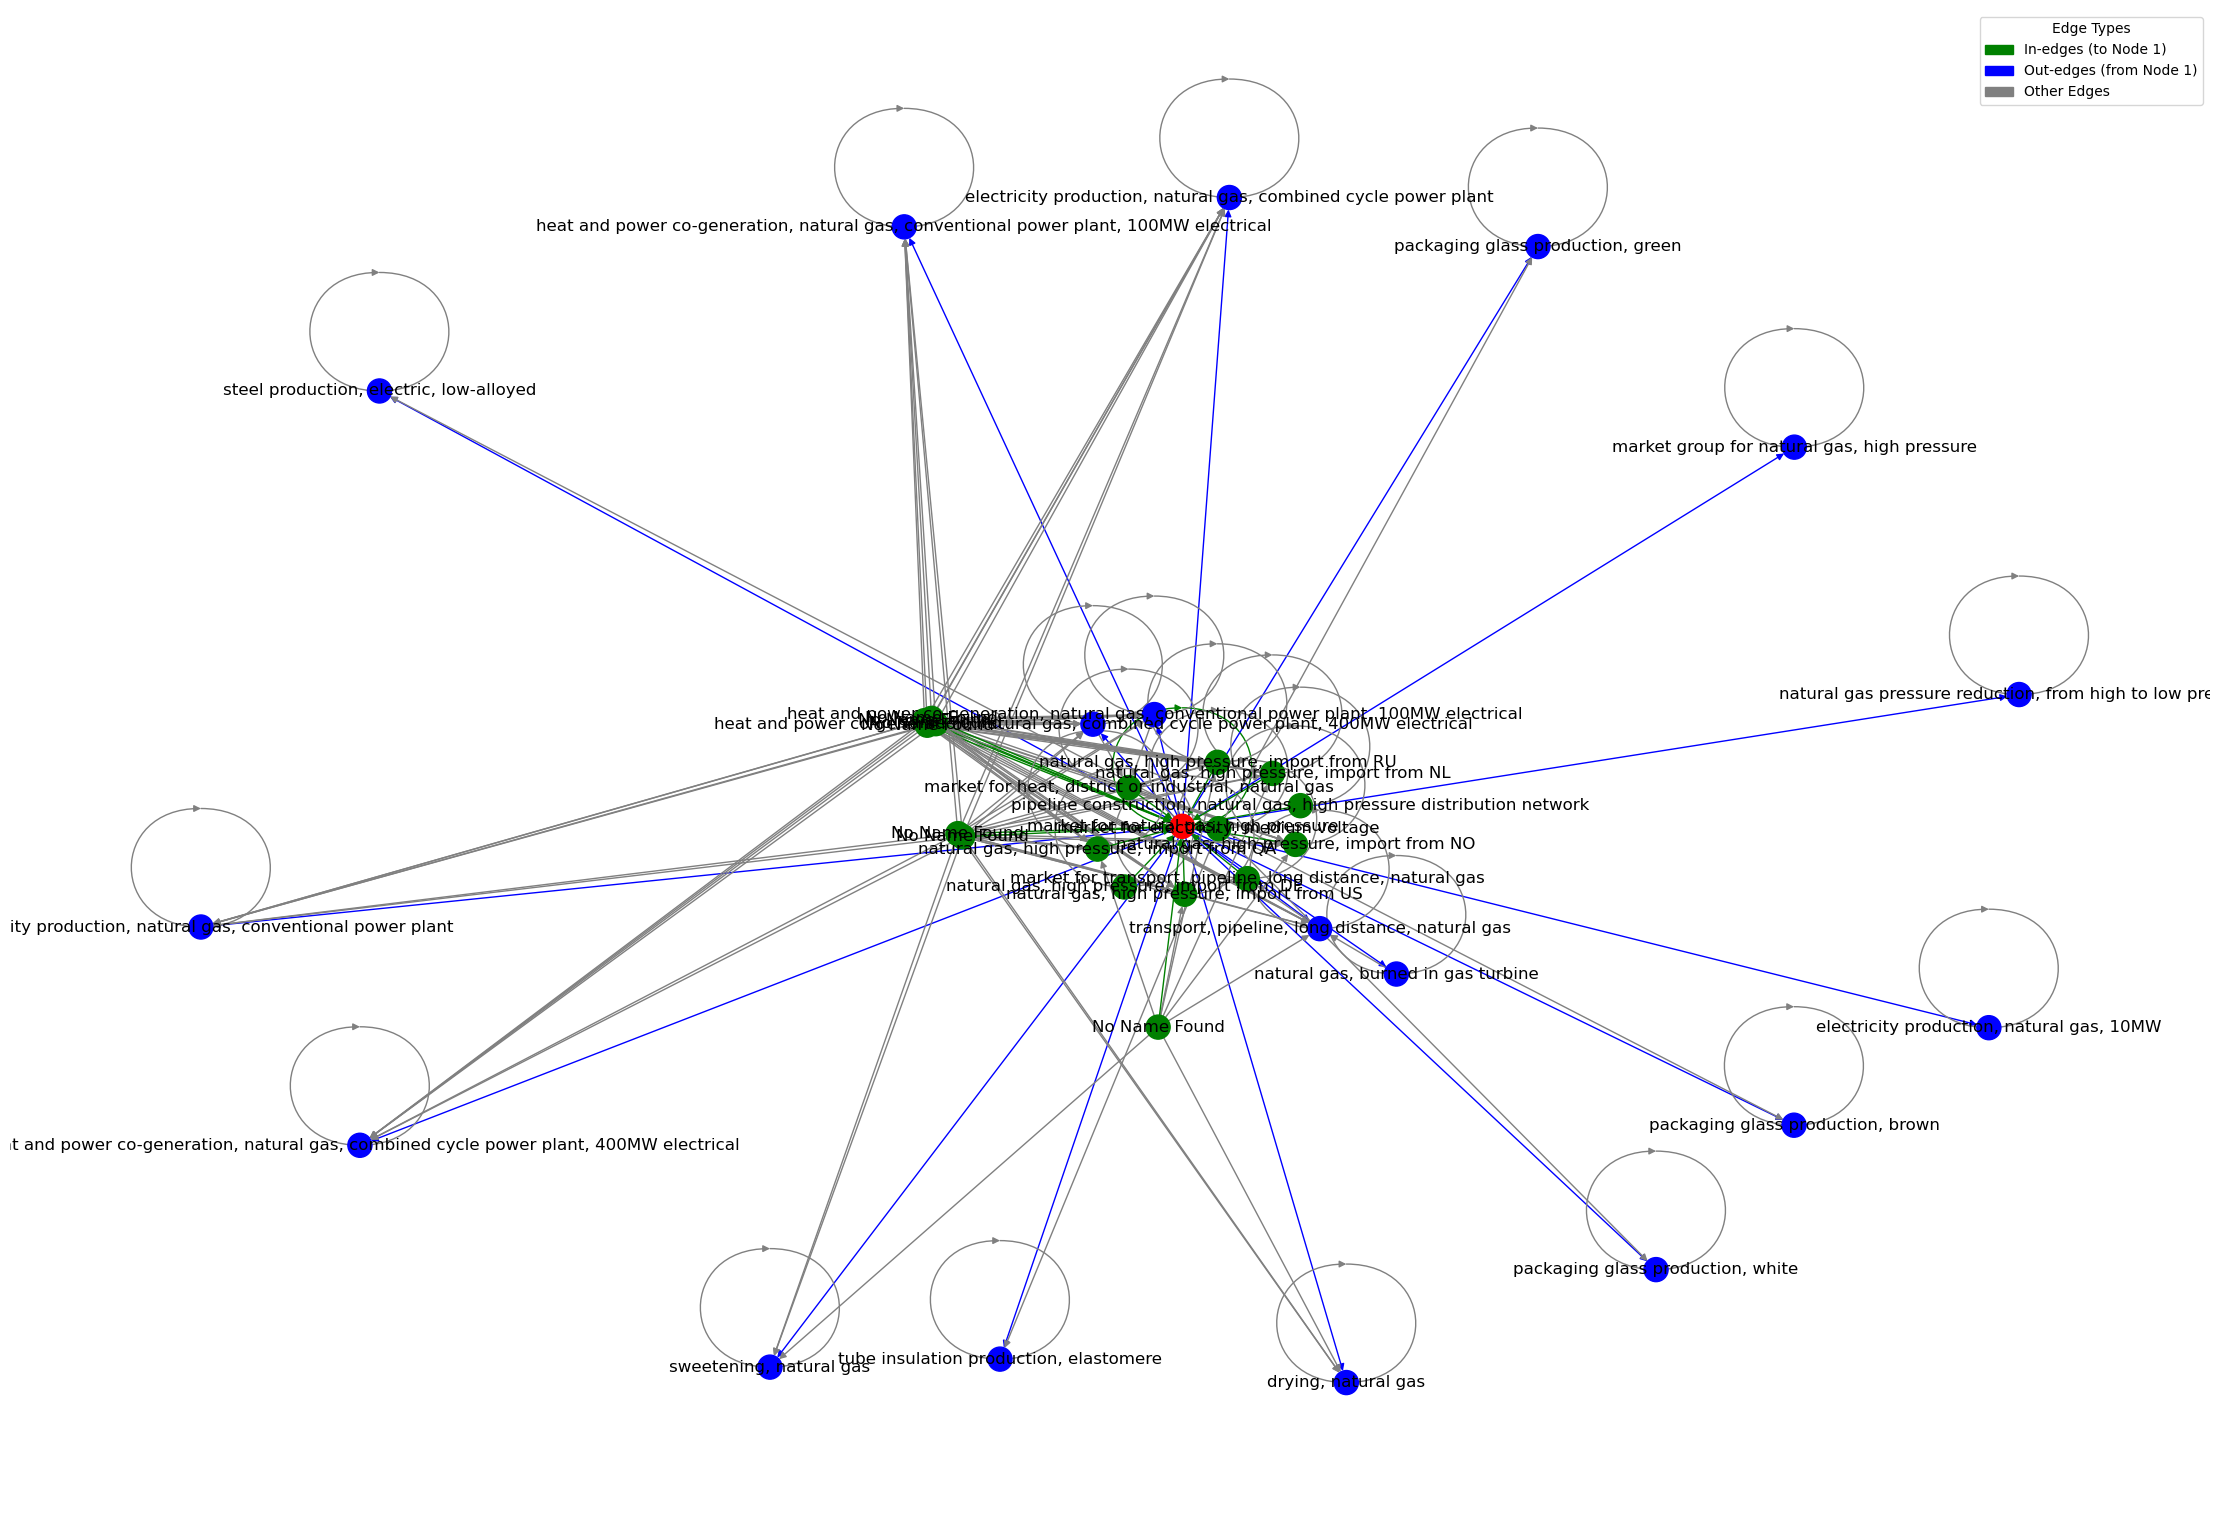

In [50]:
## select the subgraph and edges ##
node_1 = '84c52a94bf58be855ac22e6a538a16ba'
outflow = set(G.successors(node_1)) 
inflow =  set(G.predecessors(node_1)) 
neighbors = set(G.successors(node_1)) | set(G.predecessors(node_1)) 
subgraph = G.subgraph( [node_1] + list(outflow) + list(inflow))
# edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]


## set colors ## 
node_colors = [
    'red' if node in [node_1] else
    'blue' if node in outflow else
    'green' if node in inflow else
    'grey'
    for node in subgraph.nodes()
]

edge_colors = [
    'green' if u in inflow and v in [node_1] else
    'blue' if v in outflow and u in [node_1] else
    'grey'
    for u, v in subgraph.edges()
]

labels = {
    node: data.get('name', 'No Name Found')
    for node, data in subgraph.nodes(data=True)
}

## actually graph ## 
pos = nx.spring_layout(subgraph)
plt.figure(figsize=(22, 15))
nx.draw(subgraph, pos, with_labels=True, labels=labels, node_color=node_colors, edge_color=edge_colors)


## legends ## 
import matplotlib.patches as mpatches
node_legend = [
    mpatches.Patch(color='red', label='Node 1 (Highlighted)'),
    mpatches.Patch(color='blue', label='Outflow Nodes'),
    mpatches.Patch(color='green', label='Inflow Nodes'),
    mpatches.Patch(color='grey', label='Other Nodes')
]

edge_legend = [
    mpatches.Patch(color='green', label='In-edges (to Node 1)'),
    mpatches.Patch(color='blue', label='Out-edges (from Node 1)'),
    mpatches.Patch(color='grey', label='Other Edges')
]

plt.legend(handles=node_legend, loc='upper left', title="Node Types")
plt.legend(handles=edge_legend, loc='upper right', title="Edge Types")


##  plot and save ## 
plt.savefig(f"{root}/Figures/Basic_Viz/network_casestudy/high_pressure_gas_market")
plt.show()



## Miscellaneous networkx stuff

We can also pick two nodes and see what kind of edge connects them

In [51]:
G.get_edge_data('4695730316b4d42e7f6f52a22aebee63', '4695730316b4d42e7f6f52a22aebee63')

{'carbon_flow': 0.40357453499999996,
 'flow': '609fae33-2e89-4b99-8129-b1f80a6dda33',
 'type': 'production',
 'name': 'natural gas, low pressure',
 'classifications': {'CPC': ['69120: Gas distribution through mains (on own account)']},
 'production volume': 72149000000.0,
 'properties': {'carbon allocation': {'amount': 0.544635, 'unit': 'kg'},
  'carbon content': {'amount': 0.741, 'unit': 'dimensionless'},
  'carbon content, fossil': {'amount': 0.741,
   'comment': 'C content considered the same as in high pressure (consumption mix)',
   'unit': 'dimensionless'},
  'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'},
  'dry mass': {'amount': 0.735, 'unit': 'kg'},
  'heating value, gross': {'amount': 40.0,
   'comment': 'At standard conditions, and assuming amount equal to that of high pressure; based on Meili et al. (2022) section 5.5',
   'unit': 'MJ'},
  'heating value, net': {'amount': 36.0,
   'comment': 'Literature value, Source: United Nations Statistics Divisi

Search for a particular node

In [52]:
# for node, data in G.nodes()

types = defaultdict(int)

for node, data in G.nodes(data=True):
    val = data.get("type")
    types[val] += 1

print(types)

# first_product_node = next(
#     (data for node, data in G.nodes(data=True) if data.get("type") == "process"),
#     None  # Default value if no match is found
# )
# print(first_product_node)

defaultdict(<class 'int'>, {'process': 21238, None: 2420})


In [53]:
types = defaultdict(int)

for edge in G.edges(data=True):
    u, v, data = edge
    val = data.get("type")
    types[val] += 1
print(types)


defaultdict(<class 'int'>, {'technosphere': 246004, 'production': 20436, 'biosphere': 407351})


## clustering

First, get a sense of the edge weight distribution. Recall from above that edge weight could be defined as:

* production volume
* any of the values in the carbon dict:
    * allocation*carbon amount (carbon flow)

Min Weight: 0.0
Max Weight: 40601489.5
Average Weight: 4126.92992394876


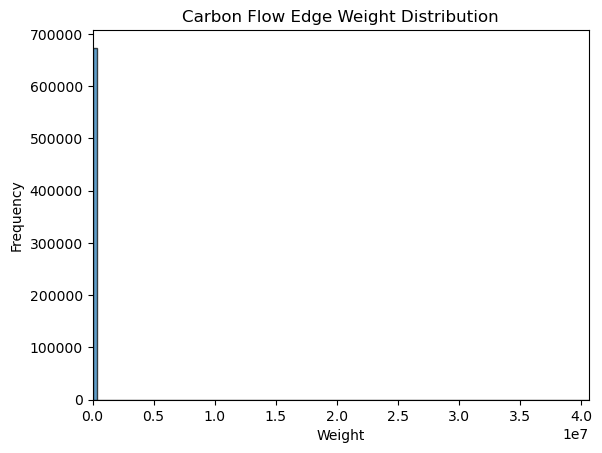

In [54]:
weights = [data['carbon_flow'] for _, _, data in G.edges(data=True)]

# Print basic statistics
# print("agh")
# print("Edge Weights:", weights)
print("Min Weight:", min(weights))
print("Max Weight:", max(weights))
avg_weight =  sum(weights) / len(weights)
print("Average Weight:", avg_weight)


# Because there are some big big outliers, we can plot just to a low value.
# We also strip out 0-1 (minimal)
plt.hist(weights, bins=100, edgecolor='black', alpha=0.7)
plt.title("Carbon Flow Edge Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.xlim(0, max(weights))
plt.show()

Min Weight: 1.0000000002
Max Weight: 244.036
Average Weight: 100.05750297189856


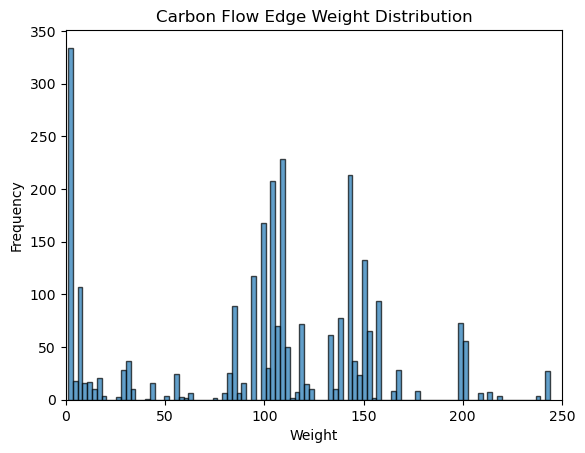

In [55]:
weights = [data['carbon_flow'] for _, _, data in G.edges(data=True)]

# Print basic statistics
# print("agh")
# print("Edge Weights:", weights)
filtered_weights = [w for w in weights if 1 < w <= 250]
print("Min Weight:", min(filtered_weights))
print("Max Weight:", max(filtered_weights))
avg_weight =  sum(filtered_weights) / len(filtered_weights)
print("Average Weight:", avg_weight)


# Because there are some big big outliers, we can plot just to a low value.
# We also strip out 0-1 (minimal)
plt.hist(filtered_weights, bins=100, edgecolor='black', alpha=0.7)
plt.title("Carbon Flow Edge Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.xlim(0, 250)
plt.show()

Min Weight: 9.282937365010801e-103
Max Weight: 1.0
Average Weight: 0.3732234623949191


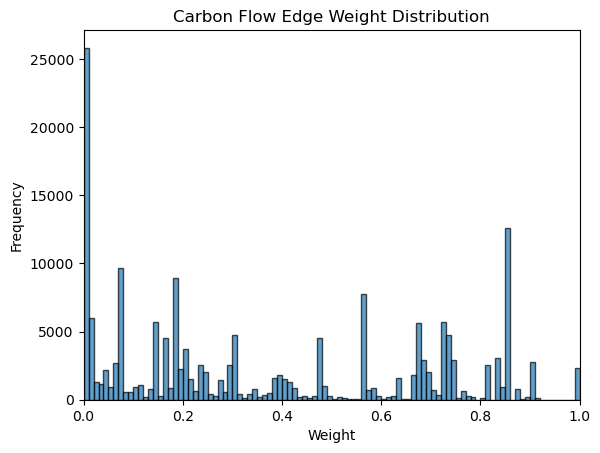

In [56]:
weights = [data['carbon_flow'] for _, _, data in G.edges(data=True)]

# Print basic statistics
# print("agh")
# print("Edge Weights:", weights)
filtered_weights = [w for w in weights if 0 < w <= 1]

print("Min Weight:", min(filtered_weights))
print("Max Weight:", max(filtered_weights))
avg_weight =  sum(filtered_weights) / len(filtered_weights)
print("Average Weight:", avg_weight)


# Because there are some big big outliers, we can plot just to a low value.
# We also strip out 0-1 (minimal)
filtered_weights = [w for w in weights if 0 < w <= 1]
plt.hist(filtered_weights, bins=100, edgecolor='black', alpha=0.7)
plt.title("Carbon Flow Edge Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.show()

## Degree Characterization

In [57]:
degree_dict = defaultdict(int)

for node in G.nodes():
    val = G.degree[node]
    degree_dict[val] += 1

degree_frame = pd.DataFrame(list(degree_dict.items()), columns=['Degree', 'Count'])
degree_frame.sort_values(by='Count', ascending=False)

,Degree,Count
4,4,1719
30,8,1006
2,5,993
21,7,810
18,6,790
...,...,...
448,692,1
449,974,1
450,1095,1
225,1291,1


In [58]:
def counts_to_frame(counts):
    """
    Given a numpy array of raw counts, return a dataframe with the
    counts.
    """
    df = counts.copy()
    df = df[df['Count'] > 0]
    df['Rank'] = df['Count'].rank(ascending=False)
    return df


In [59]:
degree_rank = counts_to_frame(degree_frame)
degree_rank.sort_values(by='Count', ascending=False).head(20)



,Degree,Count,Rank
4,4,1719,1.0
30,8,1006,2.0
2,5,993,3.0
21,7,810,4.0
18,6,790,5.0
10,10,779,6.0
70,3,640,7.0
19,9,630,8.0
16,11,485,9.0
6,16,429,10.0


Text(0, 0.5, '$\\log_{10}$ Count')

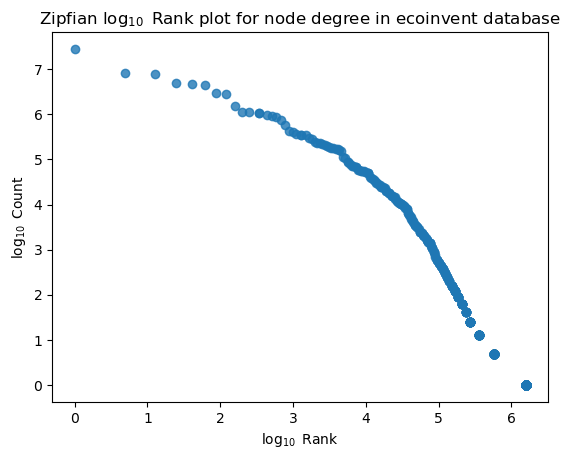

In [60]:
sns.regplot(data=degree_rank.apply(np.log), y='Count', x='Rank', fit_reg=False)
plt.title(r"Zipfian $\log_{10}$ Rank plot for node degree in ecoinvent database")
plt.xlabel(r"$\log_{10}$ Rank")
plt.ylabel(r"$\log_{10}$ Count")

In [69]:
eidb=bd.Database("ecoinvent-3.9.1-cutoff")
bio=bd.Database("ecoinvent-3.9.1-biosphere")


In [77]:
print(json.dumps(eidb.get("4503f85b8e62c3529e74f5c7cfadb155").as_dict(), indent=4))

{
    "comment": "This dataset represents the production of 1 kg of uncoated flat glass.The amount of raw materials is calculated based on the composition of flat glass. The total amount of energy is partitioned in 58% from natural gas, 38% heavy fuel oil and 5% electrical. The amount of tin yearly added to the tin bath is assumed to leave the system by air, as part of the particulates. The same with lead. Both emissions are double counted: as particulate and as emission to air. Most other emissions are a mean value of plants with and plants without abatment. It is assumed that half of water evaporates and other half is treated.\n[This dataset was already contained in the ecoinvent database version 2. It was not individually updated during the transfer to ecoinvent version 3. Life Cycle Impact Assessment results may still have changed, as they are affected by changes in the supply chain, i.e. in other datasets. This dataset was generated following the ecoinvent quality guidelines for v

In [ ]:
for act in 


Exchange: 1.0 hectare 'land use change, pasture, man made' (hectare, BR-PB, None) to 'land use change, pasture, man made' (hectare, BR-PB, None)>
Exchange: 405.5 kilogram 'market for land tenure, arable land, measured as carbon net primary productivity, pasture, man made' (kilogram, BR-PB, None) to 'land use change, pasture, man made' (hectare, BR-PB, None)>
Exchange: 1218.63652690166 kilogram 'Carbon dioxide, to soil or biomass stock' (kilogram, None, ('soil', 'agricultural')) to 'land use change, pasture, man made' (hectare, BR-PB, None)>
Exchange: 1218.63652690166 kilogram 'Carbon dioxide, in air' (kilogram, None, ('natural resource', 'in air')) to 'land use change, pasture, man made' (hectare, BR-PB, None)>


A differential characterization would be useful -- how 